# Metal Classifier

In this notebook, we train an XGBoost classifier to predict whether a system is metallic or not (bandgap <0.2 eV), and use this as an automated means of cleaning our dataset.

At the end, we assess model performance, and observe that our data is largely Tweedie-distributed once we remove the metallic systems.

In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../featurization/full_featurized_data.pkl"
data = pd.read_pickle(data_path)
target_column = ['bandgap (eV)']

# Featurization

Here, we use the Sine Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/0.3.x/tutorials/sine_matrix.html)) as our input feature to determine metallicity. We'd also tried the Ewald Summation Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/latest/tutorials/descriptors/ewald_sum_matrix.html)), but found that the Sine Matrix led to better performnance.

In [4]:
# Generate the Sine Matrix Fingerprint
max_atoms = max(data['atoms_object (unitless)'].apply(len))
sine_eigenspectrum = dscribe.descriptors.SineMatrix(n_atoms_max=max_atoms,
                                                    permutation='eigenspectrum',
                                                    sparse=False)
data['sine_matrix'] = data['atoms_object (unitless)'].progress_apply(lambda atoms: np.real(sine_eigenspectrum.create(atoms)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6351/6351 [00:11<00:00, 576.20it/s]


Next, we'll label our data. We'll say that it's a metal if its DFT bandgap is less than 0.2 eV.

In [5]:
# Manually label metals/nonmetals
bandgap_cutoff = 0.2

data['metal'] = data['bandgap (eV)'] < bandgap_cutoff
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, stratify=data['metal'], random_state=RANDOM_SEED)

# Train/Test Split
Then, we'll split up our data into a training and testing set. We'll stratify our dataset to ensure the same proportion of metals are found in both the training and test set.

In [6]:
# Pull out the X and Y values
def get_x_y(df):
    x = np.vstack(df['sine_matrix'])
    y = df['metal'].apply(int).to_numpy()
    return x,y
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

# K-Means SMOTE
At this point, our dataset is slightly imbalanced. To address this, we'll use the K-means variation of SMOTE (Imbalanced-Learn Documentation here: [Link](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html)). This is a variation on SMOTE that first performs the K-Means algorithm to generate class labels within the minority class, and then upsamples those. It's shown very promising performance for imbalanced classification problems compared to the original SMOTE algorithm (Original publication hosted at https://arxiv.org/abs/1711.00837).

To avoid contaminating our test set with information about the training set, we perform K-means SMOTE *after* the train/test split.

In [7]:
# Upsample the training set with SMOTE
knn_smote = imblearn.over_sampling.KMeansSMOTE(
    random_state=RANDOM_SEED,
    k_neighbors = 4
)
res_x, res_y = knn_smote.fit_resample(train_x, train_y)

# Hyperparameter Optimization

For this work, we'll use an XGBoost classifier. Several of its most important hyperparameters are tuned via Optuna, a Bayesian optimization framework implented in Python.

In addition to optimizing the hyperparameters, we'll also investigate the use of a scaler. Optuna can choose from the following options:
1. No scaler being applied
2. A Min/Max scaler
3. A StandardScaler

In [8]:
current_pipeline = None
best_pipeline = None

def keep_best_bandgap_model(study, trial):
    """
    Records the best bandgap model found so far
    """
    global best_pipeline
    try:
        if study.best_trial == trial:
            best_pipeline = current_pipeline
    except ValueError:
        pass

def objective(trial: optuna.Trial):
    global current_pipeline

    objective_train_x, objective_validation_x, objective_train_y, objective_validation_y = sklearn.model_selection.train_test_split(res_x, res_y, test_size=0.2)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }

    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_pipeline = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Classifier", xgboost.sklearn.XGBClassifier(**params,
                                               n_estimators=100,
                                               objective='binary:logistic',
                                               use_label_encoder=False,
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-auc')

    current_pipeline.fit(X=objective_train_x, y=objective_train_y,
                         **{
                            'XGB_Classifier__eval_set': [[objective_validation_x, objective_validation_y]],
                            'XGB_Classifier__eval_metric': 'auc',
                            'XGB_Classifier__early_stopping_rounds': 5,
                            'XGB_Classifier__callbacks': [pruning_callback],
                            'XGB_Classifier__verbose': False
                         })

    preds = current_pipeline.predict(objective_validation_x)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(objective_validation_y, pred_labels)

    return f1

We'll run Optuna using its TPE Sampler (the default; documentation here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html)) with a random seed supplied. Additionally, we'll use the HyperBand pruner to prune trials that are not promising (Documentation link here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html)).

We choose the HyperBand pruner because it's demonstrated accelerate convergence faster than many of the other pruning techniques available in Optuna: [Blogpost Link](https://tech.preferred.jp/en/blog/how-we-implement-hyperband-in-optuna/)

In [9]:
study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed=RANDOM_SEED,
        warn_independent_sampling=True,
        consider_endpoints=True,
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='maximize',
)

[I 2021-10-01 15:19:28,447] A new study created in memory with name: no-name-79edf112-a463-4d0f-958c-c98816fb37ac


In [10]:
study.optimize(objective, n_trials=1000, callbacks=[keep_best_bandgap_model])

[I 2021-10-01 15:19:28,693] Trial 0 finished with value: 0.7261029411764706 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7261029411764706.
[I 2021-10-01 15:19:28,788] Trial 1 finished with value: 0.7055793991416308 and parameters: {'learning_rate': 0.9581393536837052, 'min_split_loss': 0.8759326347420947, 'max_depth': 36, 'min_child_weight': 5.009951255234587, 'reg_lambda': 1.3669258703442726, 'reg_alpha': 1.4254040539658004, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7261029411764706.
[I 2021-10-01 15:19:28,820] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-10-01 15:19:28,858] Trial 3 pruned. Trial was pruned at iteration 1.
[I 2021-10-01 15:19:28,980] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2021-10-01 15:19:29,004] Trial 5 pr

# ROC Curves

To assess model performance, we'll print out some ROC curves here.

Although we hold out a validation set in our objective function, we do not retrain the model on the entire training set, as this validation set was also used to control the early stopping of our XGBoost model (and thus helps guard against overfitting).

Overall, we see generally good results for both our training set and our testing set.

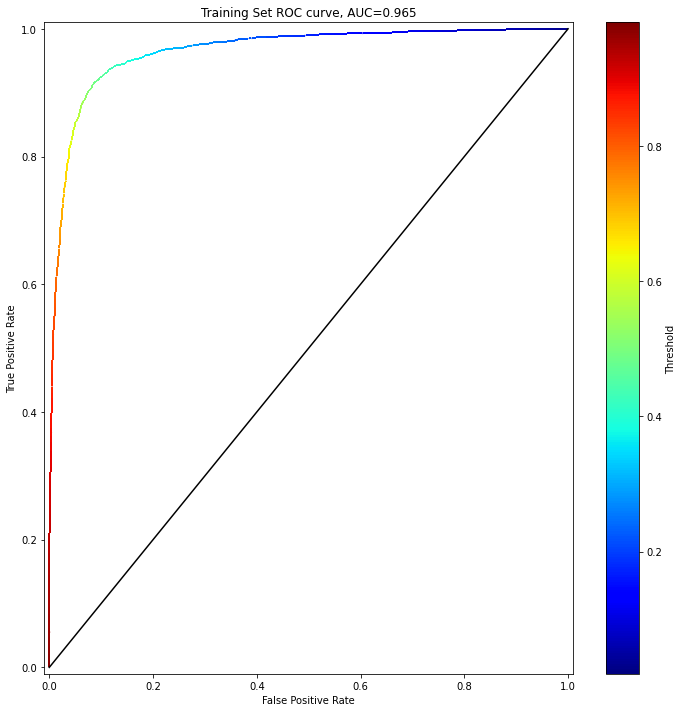

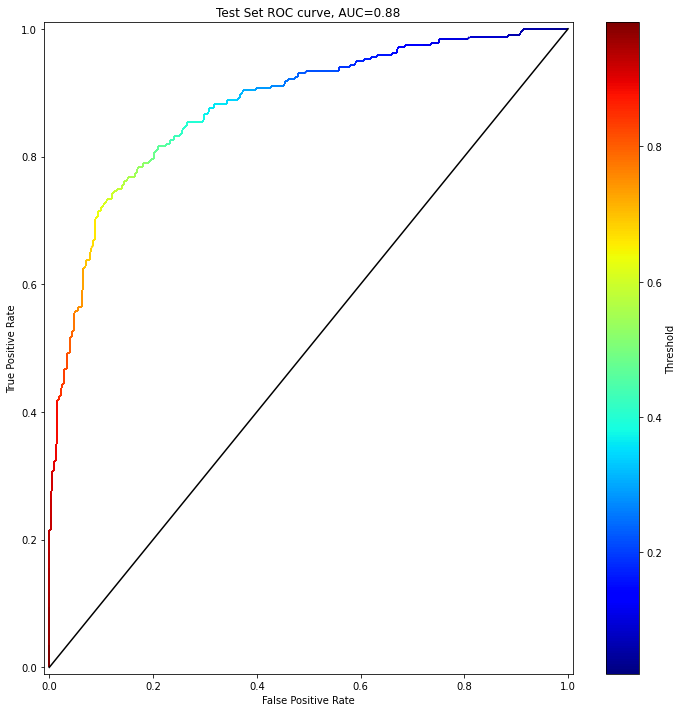

In [11]:
plot_roc = functools.partial(DigitalEcosystem.utils.figures.plot_roc, classifier=best_pipeline)

plot_roc(train_x, train_y, "Training")
plot_roc(test_x, test_y, "Test")

# Confusion Matrices

For a more fine-grained picture of our model's performance, we also draw confusion matrices here.

Overall, our classification is slightly biased towards under-prediction of the number of metals in the dataset when the model's probability cutoff is set to 0.5. Although we did not tune this cutoff, the process would be easy: we could simply lower the probability at-which something is considered to be a metal until the number of misclassified metals and nonmetals were equal in the training set.

Overall, we see good performnace in both our training and testing set, with similar error rates in both - which is a good indication that our model generalizes well to the testing set.

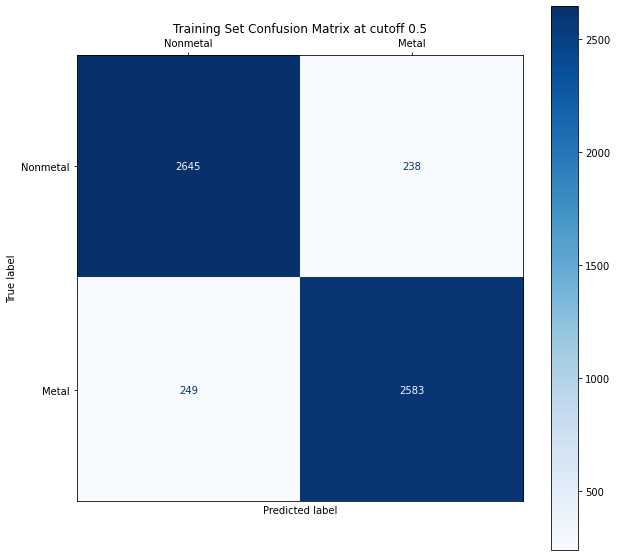

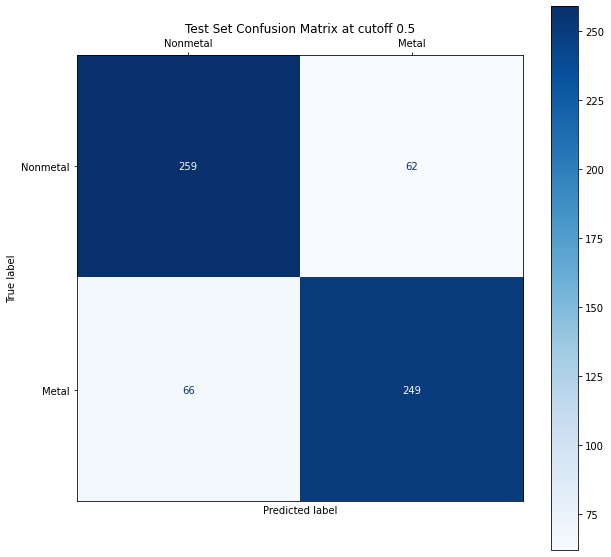

In [12]:
CUTOFF = 0.5


draw_confusion_matrix = functools.partial(DigitalEcosystem.utils.figures.draw_confusion_matrix,
                                          classifier=best_pipeline,
                                          cutoff=CUTOFF)

draw_confusion_matrix(train_x, train_y, "Training")
draw_confusion_matrix(test_x, test_y, "Test")

In [13]:
def calc_confusion_matrix_statistics(y_values, x_values, best_pipeline=best_pipeline):
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_values, y_pred=best_pipeline.predict_proba(x_values)[:,1]>CUTOFF)
    
    all_positives = sum(y_values)
    all_negatives = len(y_values) - all_positives    
    
    true_positives = confusion_matrix[1,1]
    true_negatives = confusion_matrix[0,0]
    
    false_positives = confusion_matrix[0,1]
    false_negatives = confusion_matrix[1,0]

    results = {
        "TPR": true_positives / all_positives,
        "FPR": false_positives / all_negatives,
        "Accuracy": (true_positives + true_negatives) / (all_positives + all_negatives),
        "F1 Score": (2 * true_positives) / (2 * true_positives + false_positives + false_negatives),
        "ROC AUC": sklearn.metrics.roc_auc_score(y_true=y_values, y_score = best_pipeline.predict_proba(x_values)[:,1])
    }
    return results

print("Train statistics:")
for k,v in calc_confusion_matrix_statistics(train_y, train_x).items():
    print(k,np.round(v,3))
    
print("\nTest statistics:")
for k,v in calc_confusion_matrix_statistics(test_y, test_x).items():
    print(k,np.round(v,3))

Train statistics:
TPR 0.912
FPR 0.083
Accuracy 0.915
F1 Score 0.914
ROC AUC 0.965

Test statistics:
TPR 0.79
FPR 0.193
Accuracy 0.799
F1 Score 0.796
ROC AUC 0.88


# Nonmetal Bandgap Regression

Next, we'll move to the next step of our pipeline: predicting the bandgap of nonmetals.

We'll use our trained classifier to label the dataset as "metal" or "nonmetal."

In [14]:
train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)

/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_3151/3887875597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_3151/3887875597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)


Next, we'll separate out the predicted nonmetals from our training and testing set.

In [15]:
train_metals = train[train['pred_metal'] == True]
train_nonmetals = train[train['pred_metal'] != True]

test_metals = test[test['pred_metal'] == True]
test_nonmetals = test[test['pred_metal'] != True]

# Bandgap Distribution

Before we perform the regression, let's also investigate the distribution of our data.

## Entire Dataset

First, we look at the bandgap of all data in our dataset (including metals and nonmetals). We see a very large spike at approximately 0 bandgap, followed by a tail of wider bandgaps.

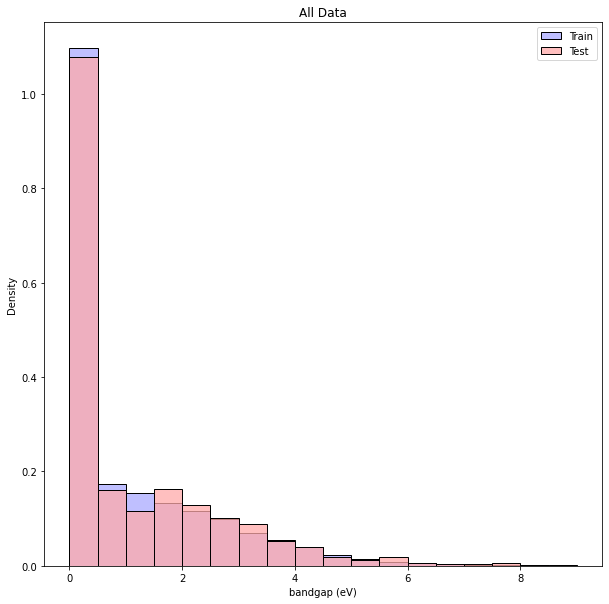

In [16]:
bins = np.arange(0,max(data['bandgap (eV)']), 0.5)
stat='density'

draw_train_test_histplot = functools.partial(DigitalEcosystem.utils.figures.save_train_test_histplot,
                                             column='bandgap (eV)',
                                             stat=stat,
                                             bins=bins)

draw_train_test_histplot(train, test,
                         "All Data",
                         "FullDatasetBandgapHistogram.jpeg")

## Predicted-Nonmetals Only

Next, we'll take a look at just rows from training and testing set which were labeled as nonmetals by our classifier.

We see that our data distribution has changed - the training set and testing set seem to be a a mixture between a Poisson distribution and a Gamma distribution - this is the classic Tweedie distribution (Wikipedia article: [Link](https://en.wikipedia.org/wiki/Tweedie_distribution)).

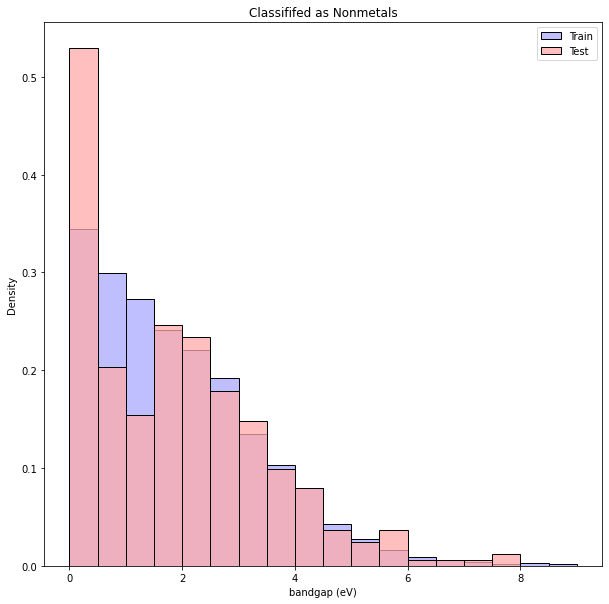

In [17]:
draw_train_test_histplot(train_nonmetals,
                         test_nonmetals,
                         "Classififed as Nonmetals",
                         "NormalHistplot.jpeg")

## Predicted Metals Only

Finally, we'll investigate our predicted metals and nonmetals. We see that, barring a few exceptions, materials that are predicted to be a metal at least tend to have a low bandgap.

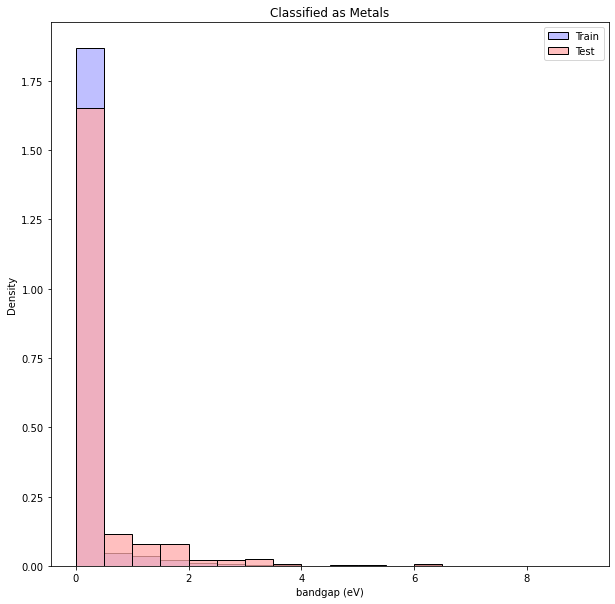

In [18]:
draw_train_test_histplot(train_metals,
                         test_metals,
                         "Classified as Metals",
                         "MetalHistplot.jpeg")

# Regression - Features

Before we start doing any work with regression, we need to choose a set of features. Because we've been finding success in the past in this problem with the Xenonpy and Matminer-derived descriptors, we'll go ahead and extract those from our dataset.

In [19]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors#%%
target = ['bandgap (eV)']

Next, we'll separate out our X and Y columns, and we'll use Numpy to remove any NaN values that made their way into the dataset.

This is an area of improvement, as we could have also imputed the NaN values instead.

In [20]:
train_x_reg = np.nan_to_num(train_nonmetals[xenonpy_matminer_descriptors].to_numpy())
train_y_reg = np.nan_to_num(train_nonmetals[target].to_numpy())

test_x_reg = np.nan_to_num(test_nonmetals[xenonpy_matminer_descriptors].to_numpy())
test_y_reg = np.nan_to_num(test_nonmetals[target].to_numpy())

# Tweedie Distribution - Investigation

Finally, before we do our regression, let's revisit the Tweedie distribution we discussed earlier.

The shape of the Tweedie distribution is controlled by a power parameter, which allows it to function as a generalization of a variety of other distributions, including the Poisson, Gamma, Normal, Gaussian, and other distributions. H2O has some very good documentation on this subject: [Link](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/tweedie_variance_power.html#:~:text=Tweedie%20distributions%20are%20a%20family,\)%3D%CF%95%CE%BCpi.).

To estimate the power, we'll walk along powers ranging from 1.0 (Poisson) to almost 2.0 (Gamma), with intermediate powers representing a Tweedie distribution. At each step, we'll take 1,000 bootstrap samples of the dataset and calculate the mean tweedie deviance relative to the mean of the bandgap. We'll take the power that results in the lowest mean tweedie deviance as an estimate of the Tweedie power.

When we attempt to fit a model on our entire dataset, we see that the data is closest to a Poisson distribution.

When we remove metals and testing set, however, we see that our data shifts to be more Tweedie - Distributed (a power between 1 and 2).Moreover, we see a slight difference in power between our training and testing set - which we can actually see in the above "Classified as Nonmetals" plot, particularly below 2 eV.

This difference in distribution between our training set and testing set is likely to contribute to error in our regression model.

Testing Set


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


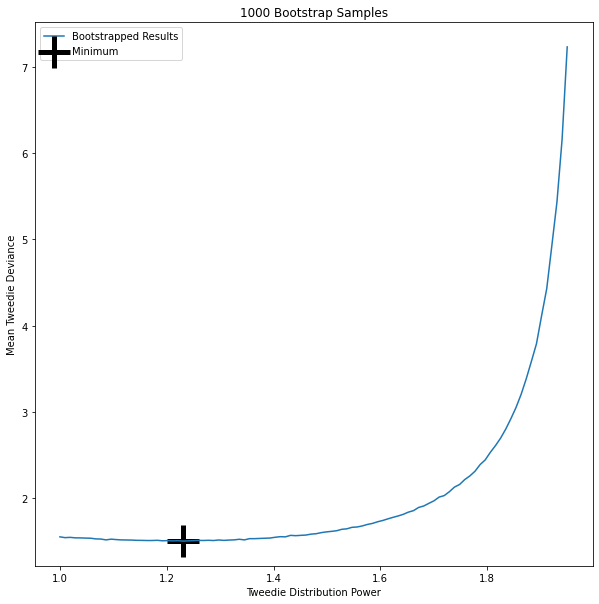

Best Pow is 1.2303030303030302 with Tweedie Deviance 1.5043287344373197
Full Dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


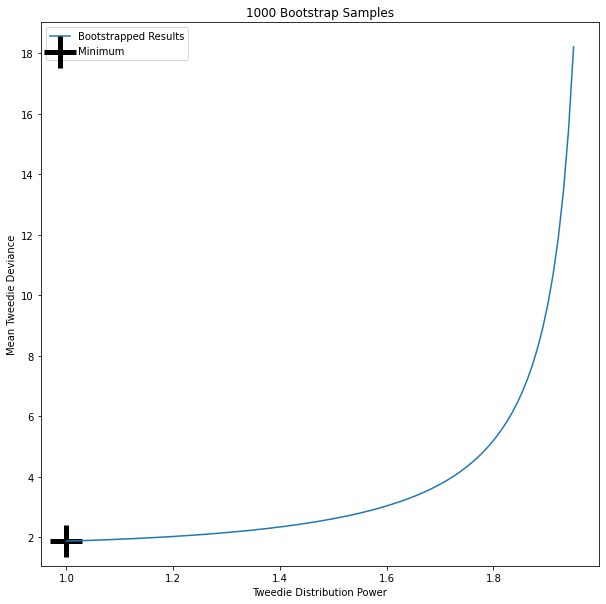

Best Pow is 1.0 with Tweedie Deviance 1.8699816004186631
Training Set


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


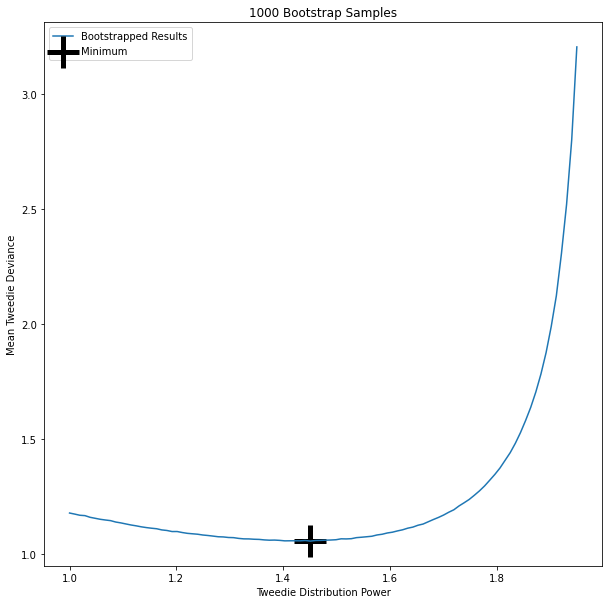

Best Pow is 1.4510101010101009 with Tweedie Deviance 1.0578270605496856


In [21]:
# Find the power that our data falls under in a tweedie distribution
def get_pow_plot(dist, filename):
    deviances = []
    n_boot_samples = 1000
    mesh_size = 100
    with tqdm.tqdm(total=mesh_size) as pbar:
        for tweedie_deviance_power in np.linspace(1,1.95,num=mesh_size):
            try:
                samples = []
                for i in range(n_boot_samples):
                    boot_sample = np.random.choice(dist, replace=True, size=len(dist))
                    samples.append(sklearn.metrics.mean_tweedie_deviance(y_true=boot_sample,
                                                                         y_pred=[abs(boot_sample.mean())]*len(boot_sample),
                                                                         power=tweedie_deviance_power))
                samp_mean = sum(samples) / len(samples)
                #samp_var = sum([sample - samp_mean for sample in samples])/ len(samples)
                deviances.append([tweedie_deviance_power, samp_mean])
            except ValueError:
                pass
            finally:
                pbar.update(1)

    plt.plot([i[0] for i in deviances],[i[1] for i in deviances], label="Bootstrapped Results")

    best_pow, best_dev = min(deviances, key=lambda i: i[1])
    plt.scatter([best_pow], [best_dev], marker="+", c='k', s=1000, lw=5, label="Minimum")

    plt.xlabel("Tweedie Distribution Power")
    plt.ylabel("Mean Tweedie Deviance")
    plt.title(f"{n_boot_samples} Bootstrap Samples")
    plt.legend()
    plt.savefig(filename)
    plt.show()
    print(f"Best Pow is {best_pow} with Tweedie Deviance {best_dev}")
    plt.close()
    return best_pow

print("Testing Set")
get_pow_plot(test_nonmetals['bandgap (eV)'].to_numpy(), "TestNonmetalTweediePower.jpeg")
print("Full Dataset")
get_pow_plot(data["bandgap (eV)"].to_numpy(), "FullDatasetTweediePower.jpeg")
print("Training Set")
best_pow=get_pow_plot(train_nonmetals["bandgap (eV)"].to_numpy(), "TrainNonmetalTweediePower.jpeg")

# Regression - XGBoost

Finally, we'll train another XGBoost model, this time for regression of the bandgap. We'll again use Optuna to tune a few of the model's hyperparameter (fewer in the interest of time). We'll also just start with a Min/Max scaler, as some previous work we'd done on thi problem indicated good performance when this was used as a scaler versus standardization or not scaling.

We'll finally draw a parity plot of our results.

[I 2021-10-01 15:24:25,917] A new study created in memory with name: no-name-e2ea469a-d0e2-47ef-8dc8-558fd9d85d3e
[I 2021-10-01 15:24:28,135] Trial 0 finished with value: 0.5394725613347413 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.5394725613347413.
[I 2021-10-01 15:24:28,209] Trial 1 pruned. Trial was pruned at iteration 1.
[I 2021-10-01 15:24:29,888] Trial 2 finished with value: 0.5224621763499983 and parameters: {'learning_rate': 0.5030831653078097, 'min_split_loss': 0.013768449590682241, 'max_depth': 78, 'min_child_weight': 8.826411906361166, 'reg_lambda': 0.7297719678027446, 'reg_alpha': 1.2307923568669874, 'scaler': 'MinMaxScaler'}. Best is trial 2 with value: 0.5224621763499983.
[I 2021-10-01 15:24:29,977] Trial 3 pruned. Trial was pruned at iteration 1.

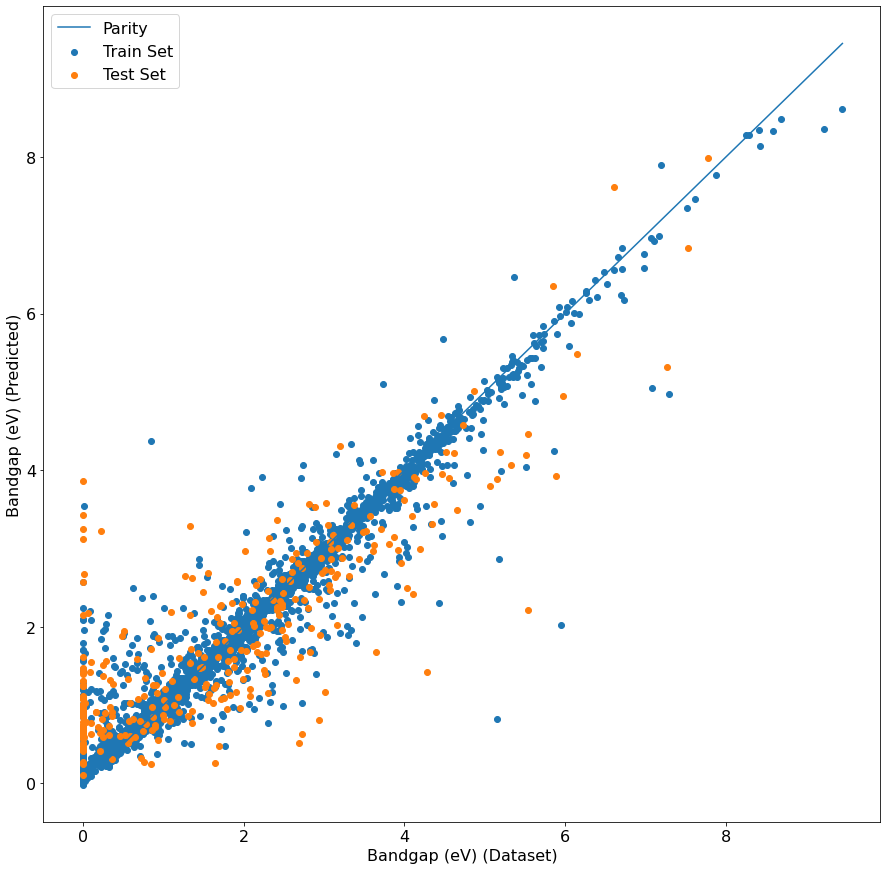

In [22]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

#TEST
objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=100,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-poisson-nloglik')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'poisson-nloglik',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_poisson_deviance(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )

    return score

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

reg_study.optimize(func=objective, n_trials=500, callbacks=[keep_best_reg])

DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                "Bandgap (eV)",
                                                "parity.jpeg")

# Regression - Results

Overall, we see okay performance of the model. Certainly not the big gains in performance that we had hoped for when removing the metals from the dataset.

One thing we could try to improve our predictions here would be to manually remove all metals from the training set, then train on those. This would likely lead to even worse performance in the case of the metal systems that had been misclassified as nonmetals - but those are already wrong by quite a lot anyway.

Below, we output the test-set error metrics, since those are the ones that really tell us if our model will generalize. Reproduced here:

| Error Metric | Test-Set Value    |
|--------------|-------------------|
| MAE          | 0.67              |
| MSE          | 0.825             |
| RMSE         | 0.909             |
| MAPE         | 543850845913702.8 |
| R2           | 0.703             |

- The MAE is comparable to a related model, MegNet [Link](https://github.com/materialsvirtuallab/megnet). MegNet is a graph convolution neural network trained on a variety of different datasets. When compared with DFT bandgaps from Materials Project (slightly different, as that dataset is of 3D materials and not 2D materials), they report a MAE of 0.33 eV for the bandgap. Considering we're not training a neural network on huge numbers of samples, this should put our MAE of 0.67 eV in perspective.
- We see a similar story for our RMSE (square root of our MSE), which is 0.909 eV.
- The Mean Absolute Percent Error (MAPE) is high, but this is because we have 0-valued entries in the dataset - this is why this metric is generally avoided in the case of data with 0s in their values (it also tends to cause models to underestinate when used as a loss function, which is another reason we don't use it as our loss function).
- Finally, we see that our R2 is 0.703, so our test set predictions are at least correlated with our dataset.



In [23]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 3.856
MAE 0.667
MSE 0.833
RMSE 0.913
MAPE 784686199451563.4
R2 0.681


# Regression - Feature Importances

Finally, in the below plot we will list the feature importances of our XGBoost model. Here are a few of the most-important features:
1. `min:GS_Energy` is a property from XenonPy. It is derived by looking at the ground-state electronic energy of the bulk cells of each element in the system (e.g. a system containing NaCl would look at the bulk cell for Na and the bulk cell for Cl). The `min` in front tells us that this version of the feature chooses the minimum amongst the ground-state DFT energies in each elemental system.
2. `var:VDW_radius_MM3` is another XenonPy property. As is the case with all the Xenonpy descriptors we use in this notebook, it is derived by looking at tabulated values for each element in the system. In this case, we take the variance of the elemntal VDW radii, as tabulated by the MM3 forcefield.
3. `ave:density` is yet another XenonPy descriptor, and is the average of the elemental densities in their respective bulk cells.

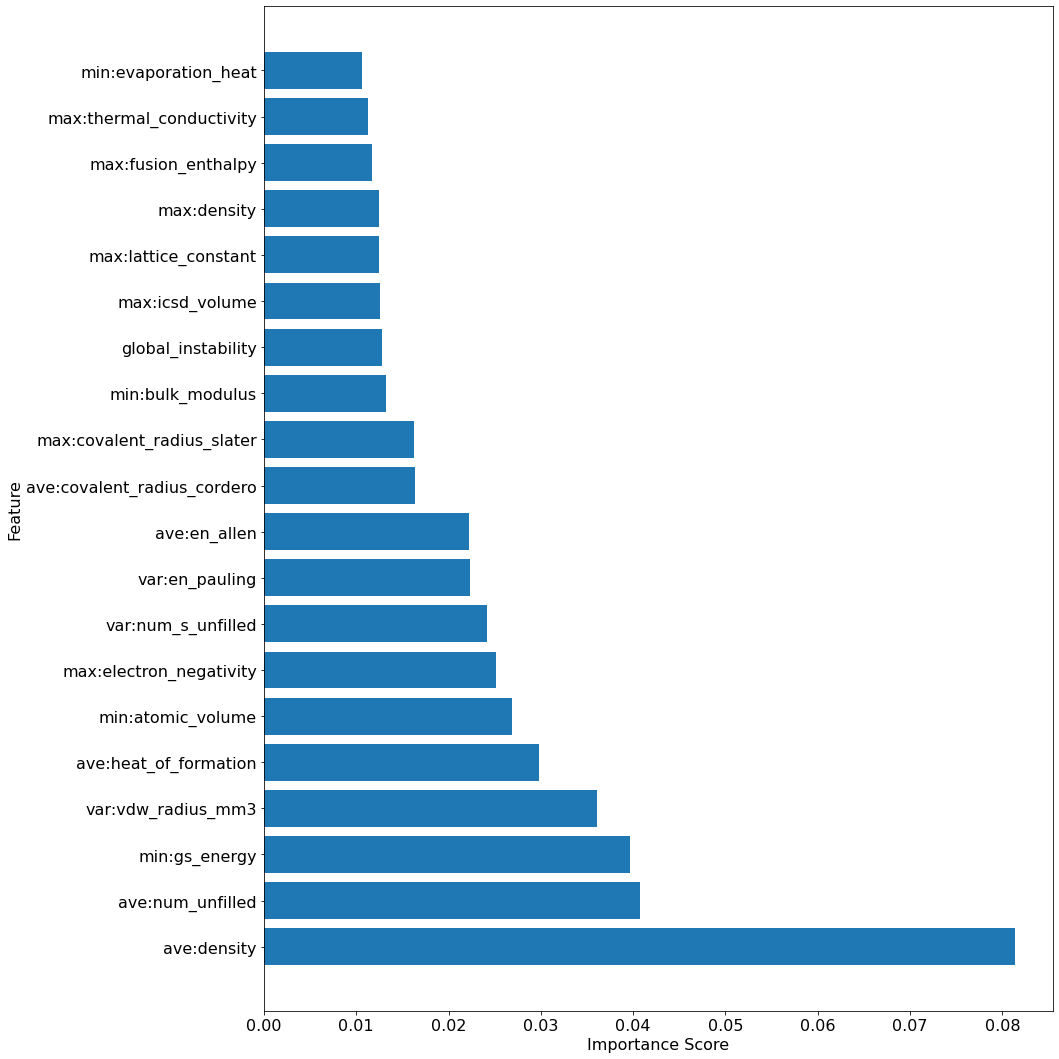

In [24]:
n_importances = 20
importances = list(zip(best_reg[1].feature_importances_, xenonpy_matminer_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

# Conclusions

Overall, in this notebook we:

1. Trained a classifier to predict whether a material is likely to be a metal or a nonmetal, with very good performance.
2. Identified that our data seems to be Tweedie-Distributed once we remove the nonmetals - which might be contributing to some of the error in the model (the high density of points at 0 eV).
3. Trained a regression model to predict the bandgap, with MAE comparable to a graph convolutional neural network that had been trained to address the bandgap of similar materials.
4. Identified several features important to the prediction of the bandgap, as determined by the importance score of our XGBoost model.